In [1]:
from data_pipeline import *
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from scipy.cluster.hierarchy import linkage, cophenet, dendrogram
from clustering import *
import seaborn as sns
import scipy.stats as stats

In [2]:
root_gene = 'CRP'
minimum_evidence = 'weak'
max_depth = np.inf
r_expr, gene_symbols, sample_names = load_data(root_gene=root_gene,
                                     minimum_evidence=minimum_evidence,
                                     max_depth=max_depth)
nb_genes = len(gene_symbols)
synthetic_name = 'rej_EColi_n{}_r{}_e{}_d{}'.format(nb_genes, root_gene, minimum_evidence, max_depth)
s_expr, s_gs = load_synthetic(synthetic_name)

assert (np.array(gene_symbols) == np.array(s_gs)).all()

# Split data into train and test sets
train_idxs, test_idxs = split_train_test(sample_names)
expr_train = r_expr[train_idxs, :]
expr_test = r_expr[test_idxs, :]

# Clip outliers
r_min = np.min(expr_train)
r_max = np.max(expr_train)
s_expr[s_expr < r_min] = r_min
s_expr[s_expr > r_max] = r_max

Found 4297 genes in datafile
Found 1208 genes in CRP regulatory network
4297 genes not in gene subset. Selecting 1076 genes ...


# Intensity histograms

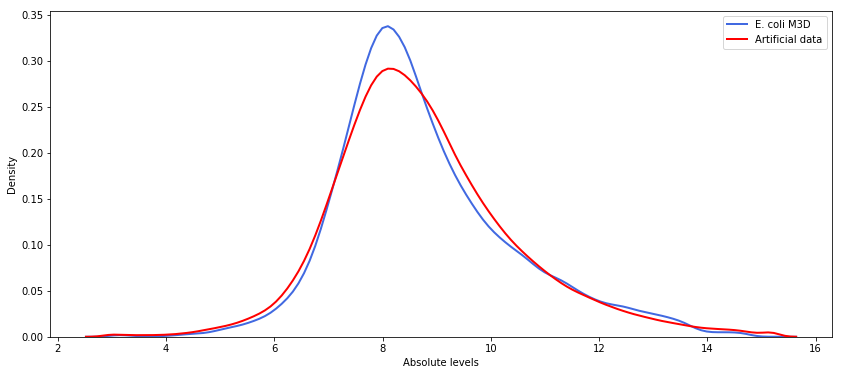

In [30]:
plt.figure(figsize=(14, 6))
ax = plot_intensities(expr_train, plot_quantiles=False)
plot_intensities(s_expr, dataset_name='Artificial data', color='red', plot_quantiles=False, ax=ax);

# Gene ranges histograms

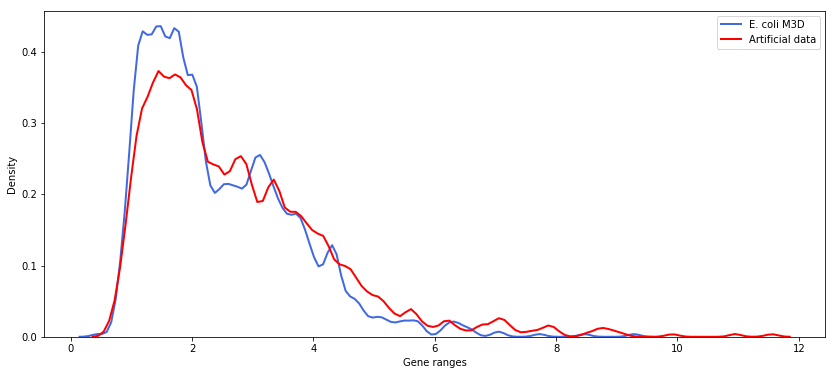

In [31]:
plt.figure(figsize=(14, 6))
# plt.subplot(121)
ax = plot_gene_ranges(expr_train)
# plt.subplot(122)
plot_gene_ranges(s_expr, dataset_name='Artificial data', color='red', ax=ax);

# TF-TG histogram (using synthetic background distribution)

In [32]:
r_tf_tg_corr, r_tg_tg_corr = compute_tf_tg_corrs(expr_train, gene_symbols)
s_tf_tg_corr, s_tg_tg_corr = compute_tf_tg_corrs(s_expr, gene_symbols)
r_back_corr = correlations_list(expr_train, expr_train)
s_back_corr = correlations_list(s_expr, s_expr)

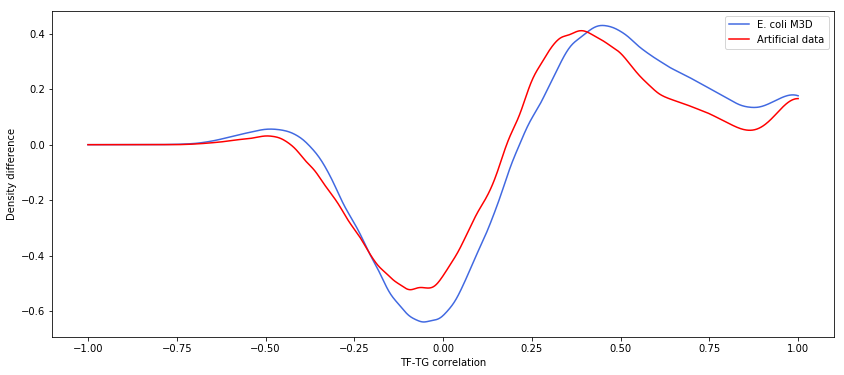

In [33]:
plt.figure(figsize=(14, 6))
ax = plot_difference_histogram(r_tf_tg_corr, r_back_corr, 'TF-TG correlation')
plot_difference_histogram(s_tf_tg_corr, s_back_corr, 'TF-TG correlation', dataset_name='Artificial data', color='red', ax=ax); 

# TG-TG histogram (using synthetic background distribution)

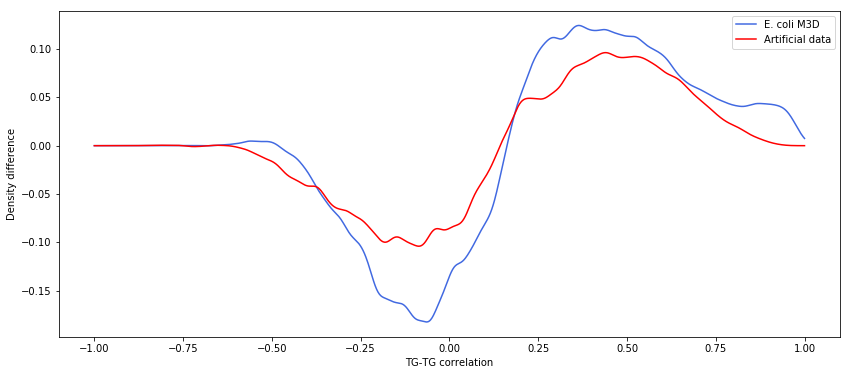

In [131]:
# plt.figure(figsize=(7, 7))
plt.figure(figsize=(14, 6))
ax = plot_difference_histogram(r_tg_tg_corr, r_back_corr, 'TG-TG correlation')
plot_difference_histogram(s_tg_tg_corr, s_back_corr, 'TG-TG correlation', dataset_name='Artificial data', color='red', ax=ax);

# Compare background distributions

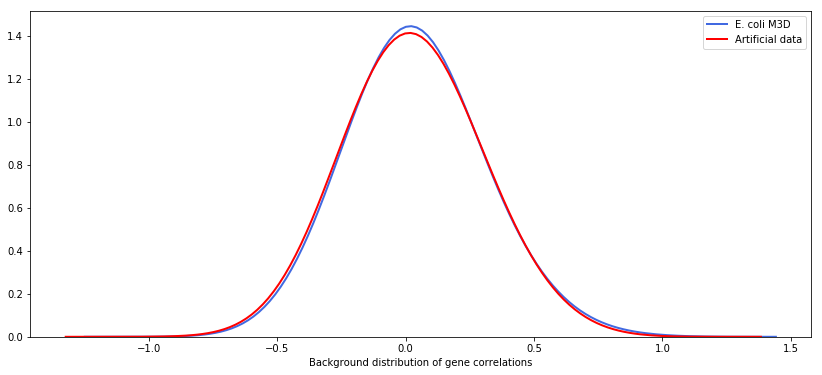

In [7]:
plt.figure(figsize=(14, 6))
ax = plot_distribution(r_back_corr, xlabel='Background distribution of gene correlations')
plot_distribution(s_back_corr, xlabel='Background distribution of gene correlations', label='Artificial data', color='red');

# TF activity histogram

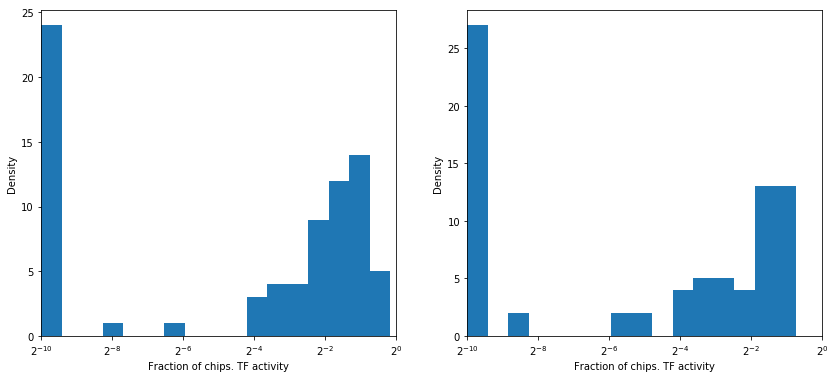

In [134]:
plt.figure(figsize=(14, 6))
plt.subplot(121)
plot_tf_activity_histogram(expr_train, gene_symbols)
plt.subplot(122)
plot_tf_activity_histogram(s_expr, gene_symbols)

# Quantitative analysis

In [3]:
scores = compute_scores(expr_train, s_expr, gene_symbols)
score_names = ['S_dist', 'S_dend', 'S_sdcc', 'S_tftg', 'S_tgtg', 'S_tfac']
print('gGAN')
for name, score in zip(score_names, scores):
    print('{}: {}'.format(name, score))

gGAN
S_dist: 0.8569137766429439
S_dend: 0.39947442082053597
S_sdcc: 0.004564327580690683
S_tftg: 0.9106449218787268
S_tgtg: 0.9042057780782787
S_tfac: 0.8874389060144783


# Analyze gene histograms

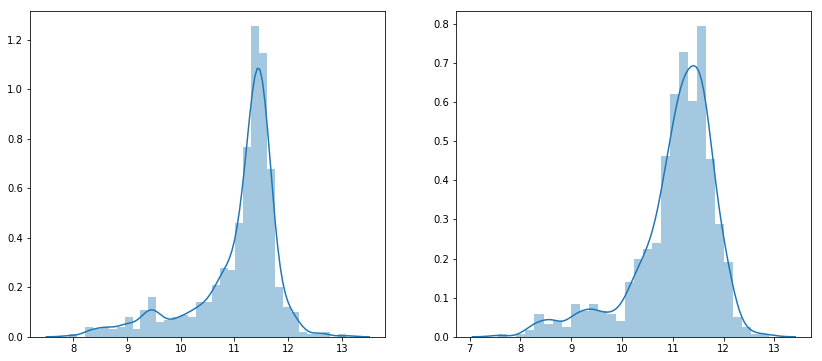

In [22]:
crp_idx = np.argwhere(np.array(gene_symbols) == 'crp')
idx = crp_idx
s_expr_crp = s_expr[:, idx].ravel()
r_expr_crp = expr_train[:, idx].ravel()
plt.figure(figsize=(14, 6))
plt.title('Expression levels of CRP');
plt.subplot(121)
ax = sns.distplot(r_expr_crp)
plt.subplot(122)
ax = sns.distplot(s_expr_crp)

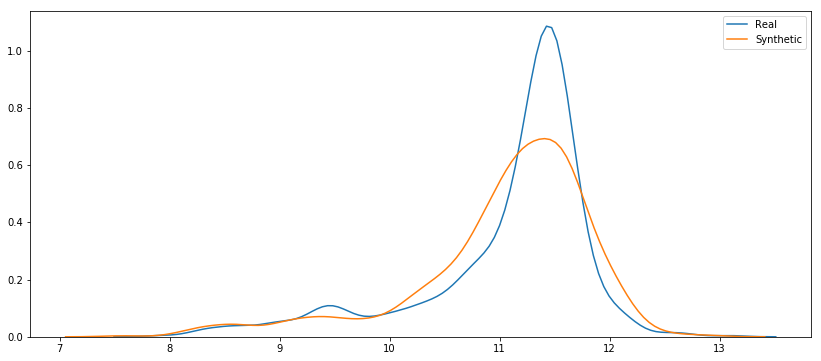

In [23]:
plt.figure(figsize=(14, 6))
r_expr_gene = expr_train[:, crp_idx]
s_expr_gene = s_expr[:, crp_idx]
ax = sns.distplot(r_expr_gene, hist=False, label='Real')
ax = sns.distplot(s_expr_gene, hist=False, label='Synthetic')

In [10]:
diag = np.diag(np.ones(nb_genes))
r_corr = pearson_correlation(expr_train, expr_train) - diag
s_corr = pearson_correlation(s_expr, s_expr) - diag
crp_idx = np.argwhere(np.array(gene_symbols) == 'crp').ravel()

In [11]:
max_corr = np.max(r_corr)
idxs = np.unravel_index(np.argmax(r_corr), r_corr.shape)
print('Maximum correlated ({:.4f}) genes in real dataset: {} and {}'.format(max_corr, gene_symbols[idxs[0]], gene_symbols[idxs[1]]))
print('Correlation in synthetic: {:.4f}'.format(s_corr[idxs[0], idxs[1]]))

Maximum correlated (0.9919) genes in real dataset: araa and arab
Correlation in synthetic: 0.6039


In [12]:
max_corr = np.max(s_corr)
idxs = np.unravel_index(np.argmax(s_corr), s_corr.shape)
print('Maximum correlated ({:.4f}) genes in synthetic dataset: {} and {}'.format(max_corr, gene_symbols[idxs[0]], gene_symbols[idxs[1]]))
print('Correlation in real: {:.4f}'.format(r_corr[idxs[0], idxs[1]]))

Maximum correlated (0.9335) genes in synthetic dataset: rplb and rplm
Correlation in real: 0.9215


In [13]:
r_corr_crp = r_corr[crp_idx, :].ravel()
s_corr_crp = s_corr[crp_idx, :].ravel()
r_max_corr_crp = np.max(r_corr_crp)
s_max_corr_crp = np.max(s_corr_crp)
sorted_idxs = np.argsort(r_corr_crp)[::-1]
print('CRP max correlated ({:.4f}) gene: {}'.format(r_max_corr_crp, gene_symbols[sorted_idxs[0]]))
print('CRP correlation with {} in synthetic: {}'.format(gene_symbols[sorted_idxs[0]], s_corr_crp[sorted_idxs[0]]))

CRP max correlated (0.7624) gene: hupa
CRP correlation with hupa in synthetic: 0.5820407632310649


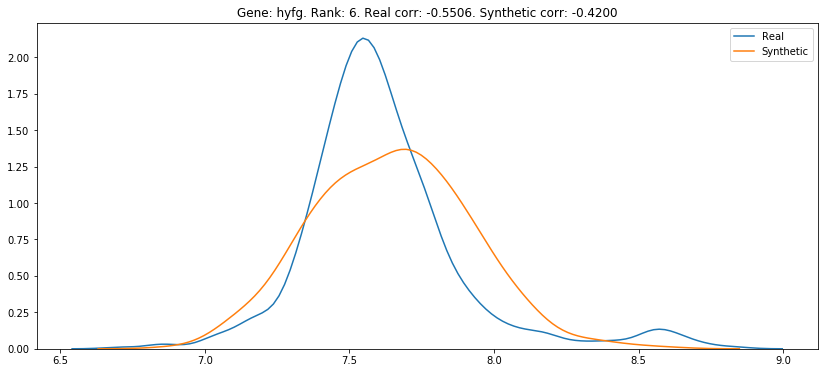

In [50]:
idx = -6
plt.figure(figsize=(14, 6))
r_expr_gene = expr_train[:, sorted_idxs[idx]]
s_expr_gene = s_expr[:, sorted_idxs[idx]]
plt.title('Gene: {}. Rank: {}. Real corr: {:.4f}. Synthetic corr: {:.4f}'.format(gene_symbols[sorted_idxs[idx]],
                                                                          max(idx+1, abs(idx)),
                                                                          r_corr_crp[sorted_idxs[idx]],
                                                                          s_corr_crp[sorted_idxs[idx]]))
ax = sns.distplot(r_expr_gene, hist=False, label='Real')
ax = sns.distplot(s_expr_gene, hist=False, label='Synthetic')

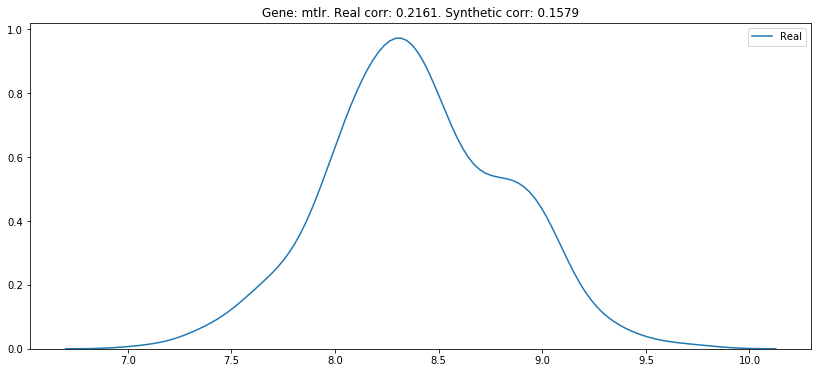

In [51]:
idx = np.argwhere(np.array(gene_symbols) == 'mtlr').ravel()[0]
plt.figure(figsize=(14, 6))
r_expr_gene = expr_train[:, idx]
s_expr_gene = s_expr[:, idx]
plt.title('Gene: {}. Real corr: {:.4f}. Synthetic corr: {:.4f}'.format(gene_symbols[idx],
                                                                          r_corr_crp[idx],
                                                                          s_corr_crp[idx]))
ax = sns.distplot(r_expr_gene, hist=False, label='Real')

# Master regulators' histograms

427


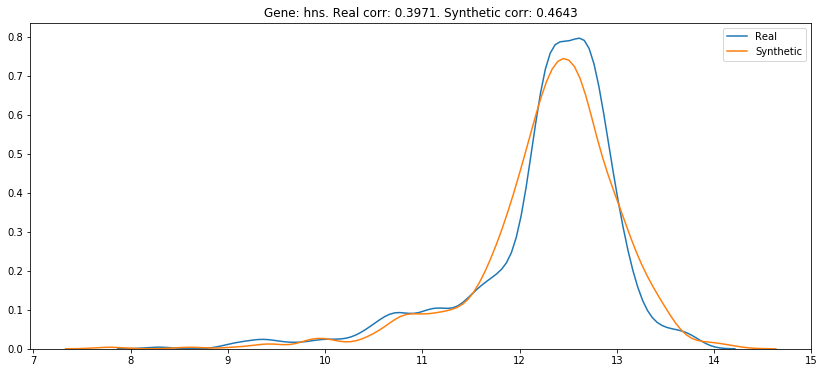

In [29]:
master_regulators = ['fis', 'hns', 'lrp', 'fnr', 'arca']
idx = 1
idx = np.argwhere(np.array(gene_symbols) == master_regulators[idx]).ravel()[0]
print(idx)
plt.figure(figsize=(14, 6))
r_expr_gene = expr_train[:, idx]
s_expr_gene = s_expr[:, idx]
plt.title('Gene: {}. Real corr: {:.4f}. Synthetic corr: {:.4f}'.format(gene_symbols[idx],
                                                                          r_corr_crp[idx],
                                                                          s_corr_crp[idx]))
ax = sns.distplot(r_expr_gene, hist=False, label='Real')
ax = sns.distplot(s_expr_gene, hist=False, label='Synthetic')